In [1]:
import os
import sys
import dotenv

from IPython.utils import io

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.ml_tools import TrainTestSplitTask

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import log_evaluation
import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map,
    create_train_val_set,
    write_optuna_capture_to_logs,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'puerto_rico_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

data_mask_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task,
)
read_merge_wf = EOWorkflow(nodes)

train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 319, 544, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 319, 544, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 319, 544, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(319, 544, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(319, 544, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(319, 544, 1), dtype=int64)
    validation_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
  }
  meta_info={
    test_count: 164983
    test_perc: 0.9507133966439241
    train_count: 4253
    train_perc: 0.02450788309054029
    validation_count: 4300
    validation_perc: 0.02477872026553568
  }
  bbox=BBox(((686070.726989808, 2007089.913413469), (691510.726989808, 2010279.913413469)), crs=CRS('32619')

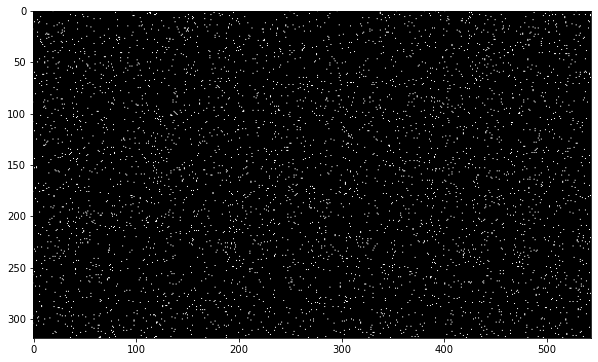

In [3]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

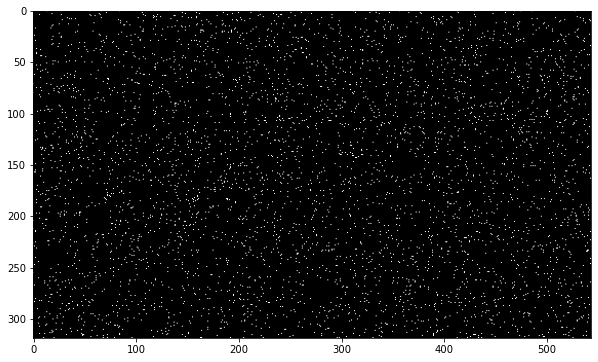

In [4]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'validation_split_valid'), colorbar=False, stretch=False)
plt.show()

### L2A Experiment

In [5]:
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'boosting_type': 'dart',
    'num_boost_round': 100,
    'force_col_wise': True,
    'seed': 42,
}

(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2A_data'))

with io.capture_output() as capture:
    model = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 00:28:39,059] A new study created in memory with name: no-name-7927317f-179e-4d3d-b2c8-e1cce8ff729f
[I 2022-05-04 00:28:39,233] Trial 0 finished with value: 1.852498547957569 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.852498547957569.
[I 2022-05-04 00:28:39,423] Trial 1 finished with value: 1.4645273458627768 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 1.4645273458627768.
[I 2022-05-04 00:28:39,571] Trial 2 finished with value: 1.4206944021594103 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 1.4206944021594103.
[I 2022-05-04 00:28:39,723] Trial 3 finished with value: 2.1451006833919126 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 1.4206944021594103.
[I 2022-05-04 00:28:39,922] Trial 4 finished with value: 1.551670686307475 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 1.4206944021594103.
[I 2022-05-04 00:28:40,096] Trial 5 finished with valu

In [6]:
y_val_hat = model.predict(val_ds.data, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(val_ds.label, y_val_hat))
rmse

1.1400531487230041

In [7]:
best_params = model.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'boosting_type': 'dart',
 'force_col_wise': True,
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0008421907750901968,
 'lambda_l2': 1.2702524155028834e-08,
 'num_leaves': 116,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.6591670111857015,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 100,
 'early_stopping_round': None}

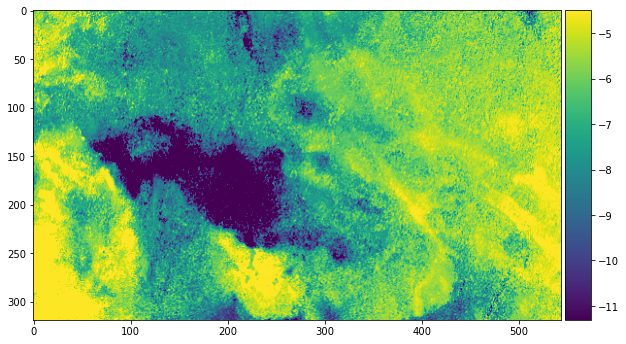

In [8]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

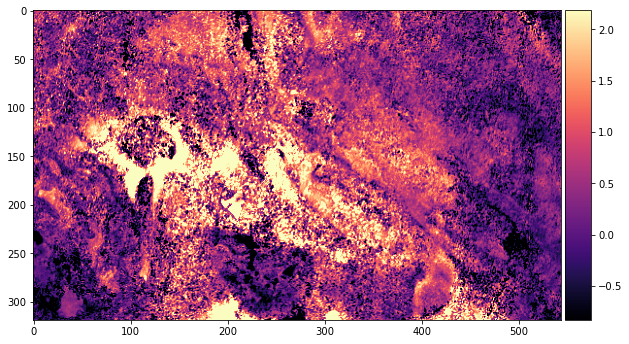

In [9]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l2a_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

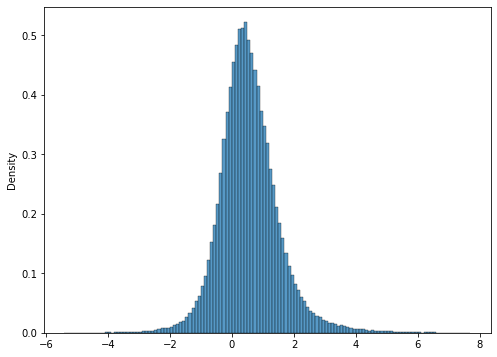

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

### L1C Experiment

In [11]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L1C_data'))

with io.capture_output() as capture:
    model = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 00:29:02,938] A new study created in memory with name: no-name-fc39362e-17b2-49a6-8fdd-8121e779bcb3
[I 2022-05-04 00:29:03,110] Trial 0 finished with value: 1.4304183845414866 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 1.4304183845414866.
[I 2022-05-04 00:29:03,295] Trial 1 finished with value: 1.3207355097426636 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 1.3207355097426636.
[I 2022-05-04 00:29:03,437] Trial 2 finished with value: 1.6950220476959696 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 1.3207355097426636.
[I 2022-05-04 00:29:03,601] Trial 3 finished with value: 1.625875593409439 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 1.3207355097426636.
[I 2022-05-04 00:29:03,800] Trial 4 finished with value: 1.4878038017801924 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 1.3207355097426636.
[I 2022-05-04 00:29:03,976] Trial 5 f

In [12]:
y_val_hat = model.predict(val_ds.data, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(val_ds.label, y_val_hat))
rmse

1.1036135563098444

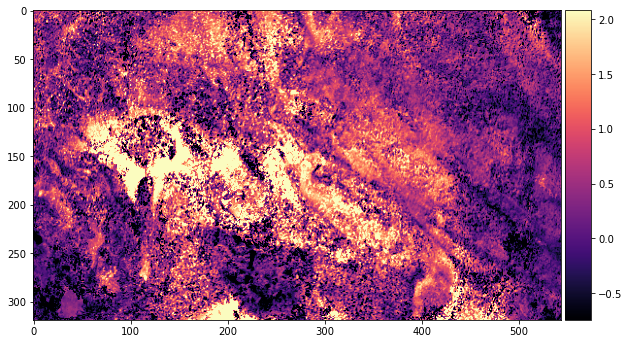

In [13]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l1c_sdb_estimation_values, l1c_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)

masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l1c_sdb_errors = l1c_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l1c_sdb_errors, cmap='magma')
plt.show()

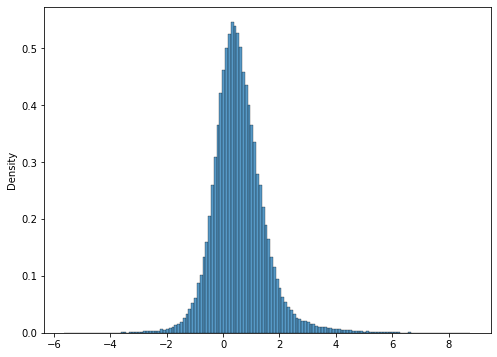

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all
sns.histplot(l1c_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

### Acolite Experiment

In [15]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2R_data'))

with io.capture_output() as capture:
    model = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 00:29:28,373] A new study created in memory with name: no-name-9c363b1e-8b87-4fff-9716-b10b2bc63ee1
[I 2022-05-04 00:29:28,567] Trial 0 finished with value: 1.6143733191204532 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 1.6143733191204532.
[I 2022-05-04 00:29:28,745] Trial 1 finished with value: 1.7102360944172745 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 1.6143733191204532.
[I 2022-05-04 00:29:28,920] Trial 2 finished with value: 1.6255485932177465 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 1.6143733191204532.
[I 2022-05-04 00:29:29,064] Trial 3 finished with value: 1.841416745146041 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.6143733191204532.
[I 2022-05-04 00:29:29,240] Trial 4 finished with value: 1.674604503364926 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 1.6143733191204532.
[I 2022-05-04 00:29:29,374] Trial 5 fi

In [16]:
y_val_hat = model.predict(val_ds.data, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(val_ds.label, y_val_hat))
rmse

1.2435017788123461

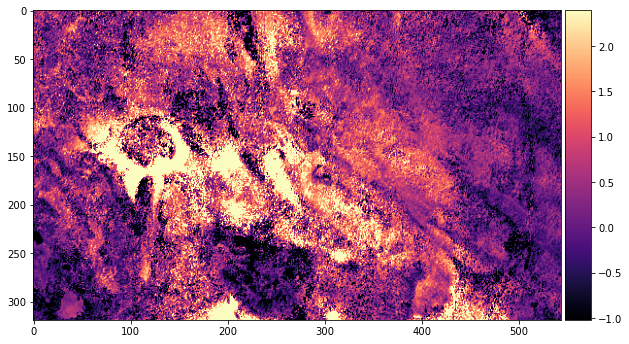

In [17]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2R_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)

masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
acolite_sdb_errors = acolite_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

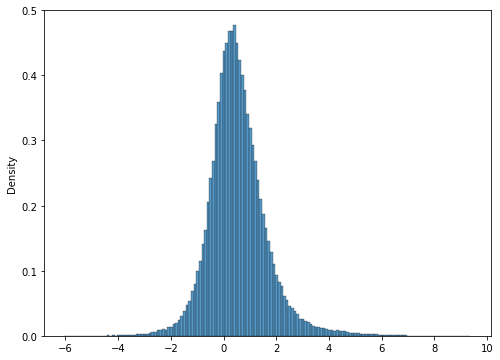

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

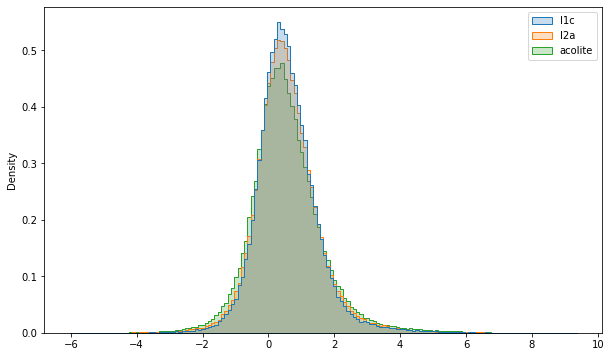

In [19]:
residuals_df = pd.DataFrame({
    'l1c': l1c_sdb_residuals,
    'l2a': l2a_sdb_residuals,
    'acolite': acolite_sdb_residuals
})

plt.figure(figsize=(10, 6))
sns.histplot(residuals_df, binwidth=0.1, stat='density', element='step', common_norm=False)
plt.show()